In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from graphviz import Digraph
from dowhy import gcm
from datetime import datetime, timedelta

In [47]:
import sys
sys.path.append('../src')
from create_synthetic_data import generate_fashion_data_with_brand, inject_anomalies_by_date
from pathway import CausalRootCauseAnalyzer, ScmBuilder, CausalResultsVisualizer
from anomaly import AnomalyDetector

In [48]:
# Example usage
start_date = '2023-01-01'
end_date = '2023-12-30'
df = generate_fashion_data_with_brand(start_date, end_date)

In [49]:
df['Category'] = df['MERCHANDISE_HIERARCHY'].str.split('.').str[0]
df['SubCategory'] = df['MERCHANDISE_HIERARCHY'].str.split('.').str[1] 

In [108]:
anomaly_schedule = {
    '2023-01-10': ('ExcessiveDiscount', 0.2, 'PricingError', 'Apparel'),
    '2023-06-10': ('COGSOverstatement', -0.2, 'SupplierIssue', 'Footwear'),
    '2023-09-10': ('FulfillmentSpike', -1, 'LogisticsIssue', 'Beauty'),
    '2023-12-10': ('ReturnSurge', 3, 'QualityIssue', 'Accessories')
}

df_anomalous = inject_anomalies_by_date(df, anomaly_schedule)

In [109]:
df_anomalous.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,UNIT_COST,ORDERDATE,SALES,DISCOUNT,NET_SALES,STATUS,QTR_ID,...,SHIPPING_REVENUE,PROFIT,PROFIT_MARGIN,IS_MARGIN_NEGATIVE,CUSTOMER_LOYALTY,Category,SubCategory,ANOMALY_TYPE,SEVERITY,ROOT_CAUSE
0,45261,4,57.20,15.57,2023-01-01,228.80,0.00,228.80,Shipped,1,...,0.0,133.06,58.16,False,New,Apparel,Men,None,None,None
1,34693,3,120.30,30.81,2023-01-01,360.90,43.31,317.59,Shipped,1,...,0.0,185.85,58.52,False,New,Apparel,Men,None,None,None
2,70012,3,63.14,13.73,2023-01-01,189.42,22.73,166.69,Shipped,1,...,0.0,96.84,58.10,False,Loyal,Apparel,Men,None,None,None
3,84570,1,36.43,8.76,2023-01-01,36.43,6.56,29.87,In Process,1,...,3.0,12.09,40.48,False,New,Apparel,Men,None,None,None
4,42330,2,135.41,38.01,2023-01-01,270.82,43.33,227.49,Shipped,1,...,0.0,121.40,53.36,False,Loyal,Apparel,Men,None,None,None


In [110]:
# Convert 'ORDERDATE' to datetime objects if not already done
df_anomalous['ORDERDATE'] = pd.to_datetime(df_anomalous['ORDERDATE'])

# Define categorical variables for grouping
categorical_variables = [
    "Category", "SubCategory", "PROMO_CODE", "SALES_CHANNEL", "CUSTOMER_LOYALTY"
]

# Define numerical/fiscal variables for aggregation
numerical_variables = [
    "PRICEEACH", "UNIT_COST", "QUANTITYORDERED", "SALES", "DISCOUNT", "NET_SALES",
    "FULFILLMENT_COST", "MARKETING_COST", "RETURN_COST", "COST_OF_GOODS_SOLD",
    "SHIPPING_REVENUE", "PROFIT", "PROFIT_MARGIN", "IS_MARGIN_NEGATIVE"
]

# Define aggregation methods for numerical variables
aggregation_dict = {
    "PRICEEACH": "mean",  # Average price per unit within each group
    "UNIT_COST": "mean",  # Average cost per unit
    "QUANTITYORDERED": "sum",  # Total units sold within each group per day
    "SALES": "sum",  # Total sales revenue
    "DISCOUNT": "sum",  # Total discounts applied
    "NET_SALES": "sum",  # Total net sales
    "FULFILLMENT_COST": "sum",  # Total fulfillment costs
    "MARKETING_COST": "sum",  # Total marketing costs
    "RETURN_COST": "sum",  # Total return costs
    "COST_OF_GOODS_SOLD": "sum",  # Total cost of goods sold
    "SHIPPING_REVENUE": "sum",  # Total shipping revenue
    "PROFIT": "sum",  # Total profit
    "PROFIT_MARGIN": "mean",  # Average profit margin (weighted by NET_SALES if needed)
    "IS_MARGIN_NEGATIVE": "mean"  # Proportion of negative margins (0 or 1)
}

# Group by ORDERDATE and categorical variables, then aggregate numerical variables
df_agg = df_anomalous.groupby([pd.Grouper(key='ORDERDATE', freq='D')] + categorical_variables).agg(aggregation_dict).reset_index()

df_agg.head()

,ORDERDATE,Category,SubCategory,PROMO_CODE,SALES_CHANNEL,CUSTOMER_LOYALTY,PRICEEACH,UNIT_COST,QUANTITYORDERED,SALES,DISCOUNT,NET_SALES,FULFILLMENT_COST,MARKETING_COST,RETURN_COST,COST_OF_GOODS_SOLD,SHIPPING_REVENUE,PROFIT,PROFIT_MARGIN,IS_MARGIN_NEGATIVE
0,2023-01-01,Accessories,Handbags,NO_CODE,B2BCustomers:Corporate Client,New,323.77,170.63,1,323.77,0.00,323.77,7.00,2.14,9.71,170.63,0.0,134.29,41.480,0.0
1,2023-01-01,Accessories,Handbags,NO_CODE,B2BCustomers:Reseller,New,380.91,199.61,1,380.91,0.00,380.91,7.70,3.12,11.43,199.61,0.0,159.05,41.760,0.0
2,2023-01-01,Accessories,Handbags,NO_CODE,OnlineStore:Mobile App,New,377.53,224.26,1,377.53,0.00,377.53,9.24,3.27,11.33,224.26,0.0,129.43,34.280,0.0
3,2023-01-01,Accessories,Handbags,PARTY10,B2BCustomers:Corporate Client,New,189.05,107.64,2,378.10,43.56,334.54,15.40,6.83,10.03,215.28,0.0,87.00,25.665,0.0
4,2023-01-01,Accessories,Handbags,PARTY10,OnlineStore:Website,Loyal,254.15,135.30,1,254.15,16.27,237.88,7.70,3.63,7.14,135.30,0.0,84.11,35.360,0.0


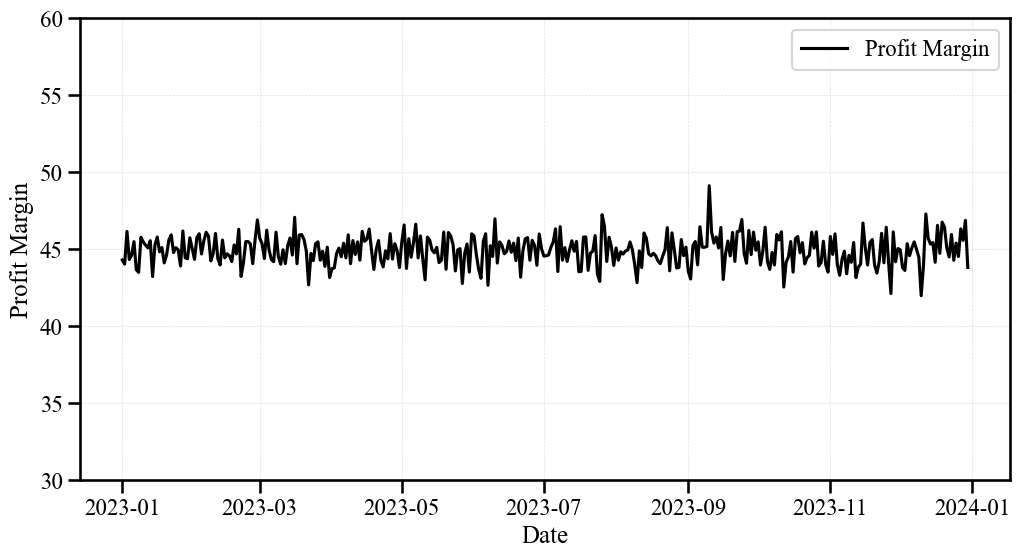

In [111]:
plt.figure(figsize=(12, 6))
# Plot the original time series.
df_anomaly_1 = df_agg.groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
plt.plot(df_anomaly_1["ORDERDATE"], df_anomaly_1['PROFIT_MARGIN'], 
         label='Profit Margin', color='black')

# Set plot labels and grid.
plt.xlabel("Date")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.ylim(30,60)
plt.legend()
plt.show()


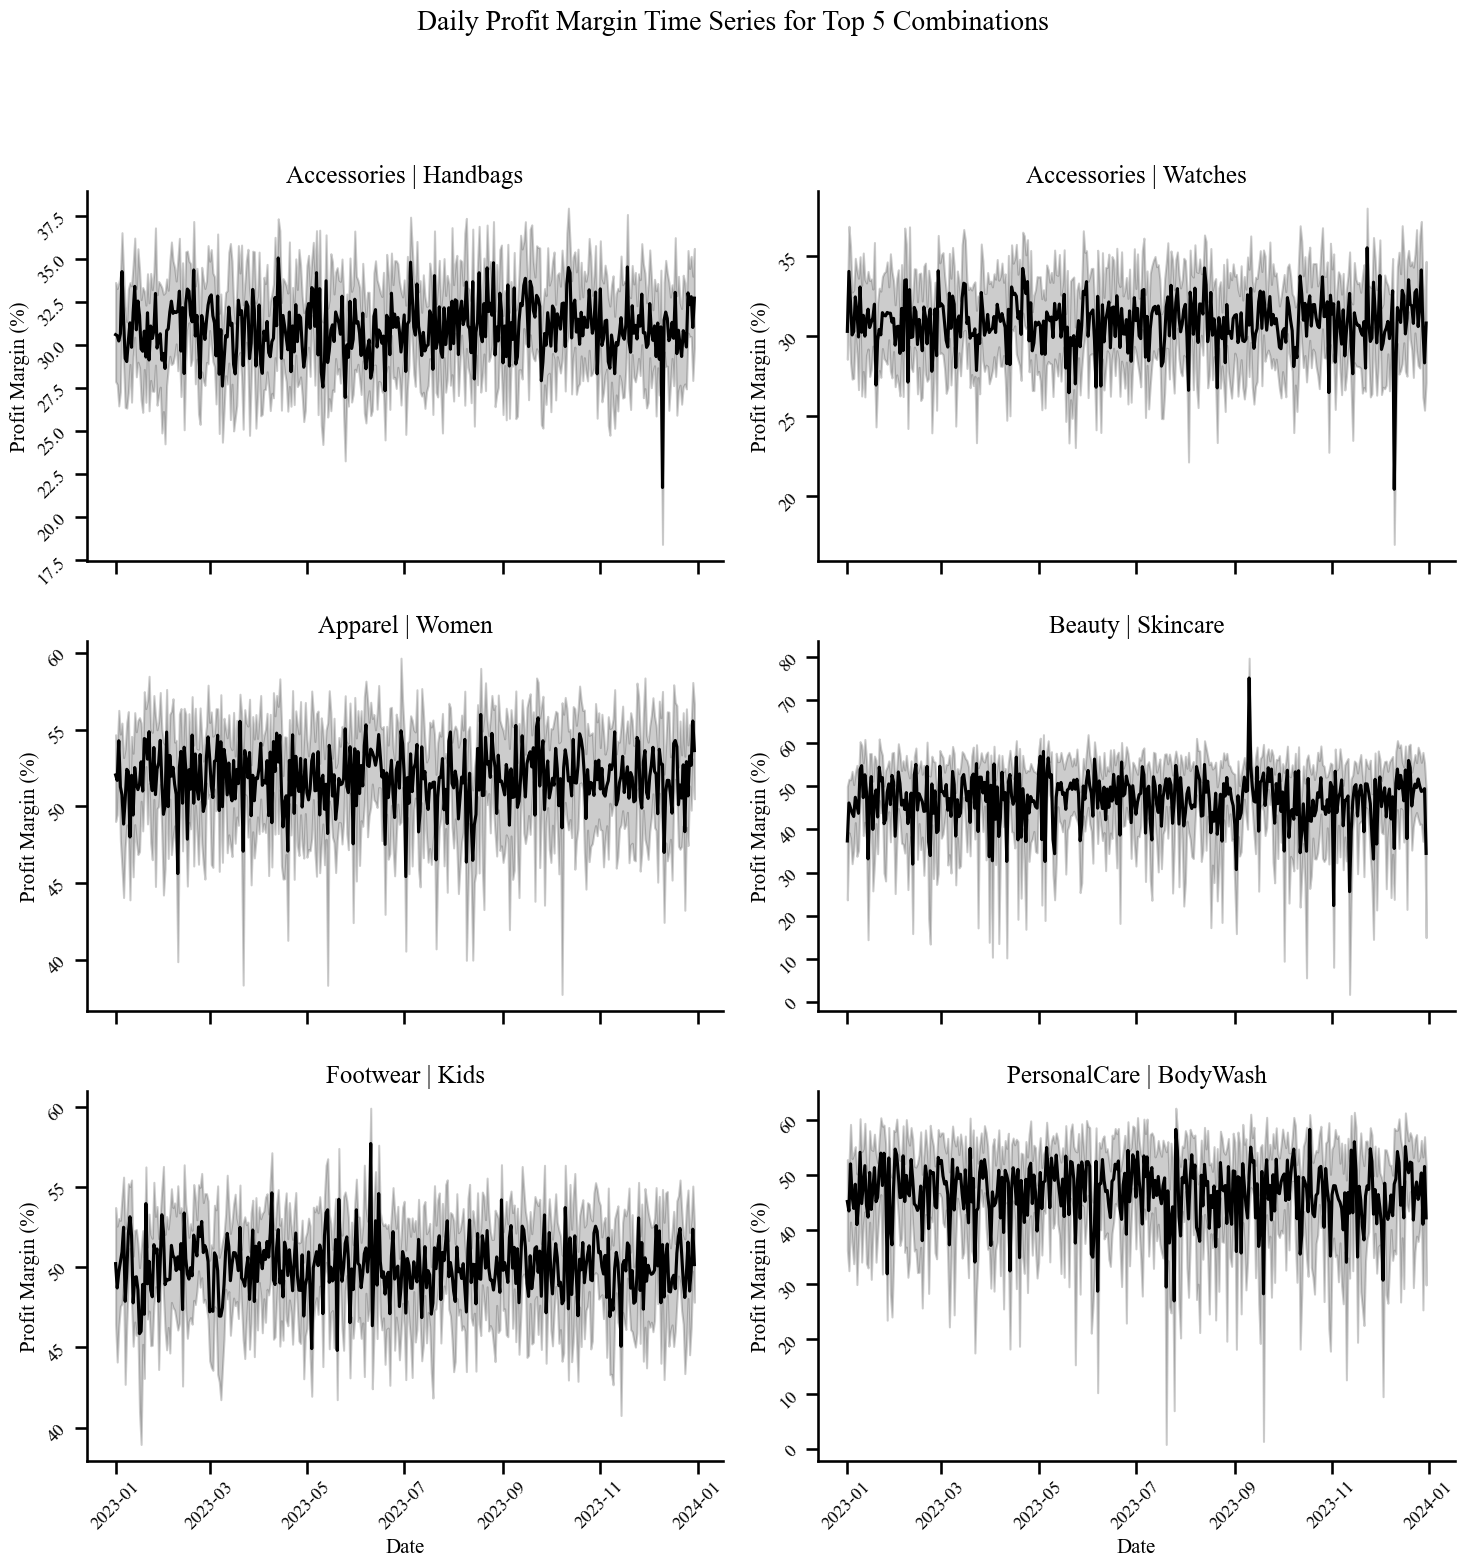

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_context("talk", font_scale=1) 
# Ensure ORDERDATE is in datetime format
df_agg['ORDERDATE'] = pd.to_datetime(df_agg['ORDERDATE'])

# Define the categorical variables for grouping
categorical_variables = [
     "Category", "SubCategory"
]

# Identify the top 5 most frequent combinations of the categorical variables
combination_counts = df_agg.groupby(categorical_variables).size().nlargest(6).reset_index(name='count')
top_combinations = combination_counts[categorical_variables]

# Filter df_agg to include only the top combinations
df_plot = df_agg.merge(top_combinations, on=categorical_variables, how='inner')

# Create a unique identifier for each combination for labeling
df_plot['Combination'] = df_plot['Category']  + ' | ' + df_plot['SubCategory']

g = sns.FacetGrid(df_plot, col='Combination', col_wrap=2, height=5, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'ORDERDATE', 'PROFIT_MARGIN', color='black')

# Customize titles and labels for each axis
for ax in g.axes.flat:
    current_title = ax.get_title().replace('Combination = ', '')  # Clean up the default title
    ax.set_title(current_title, fontsize=18, fontname='Times New Roman')
    ax.set_xlabel('Date', fontsize=15, fontfamily='Times New Roman')
    ax.set_ylabel('Profit Margin (%)', fontsize=15, fontfamily='Times New Roman')
    ax.tick_params(axis='both', labelsize=13, labelrotation=45, labelcolor='black')

# Add a figure-wide title
g.fig.suptitle('Daily Profit Margin Time Series for Top 5 Combinations', fontsize=20, y=1.05, fontfamily='Times New Roman')

# Adjust layout to prevent overlap
g.tight_layout()

# Show the plot
plt.show()

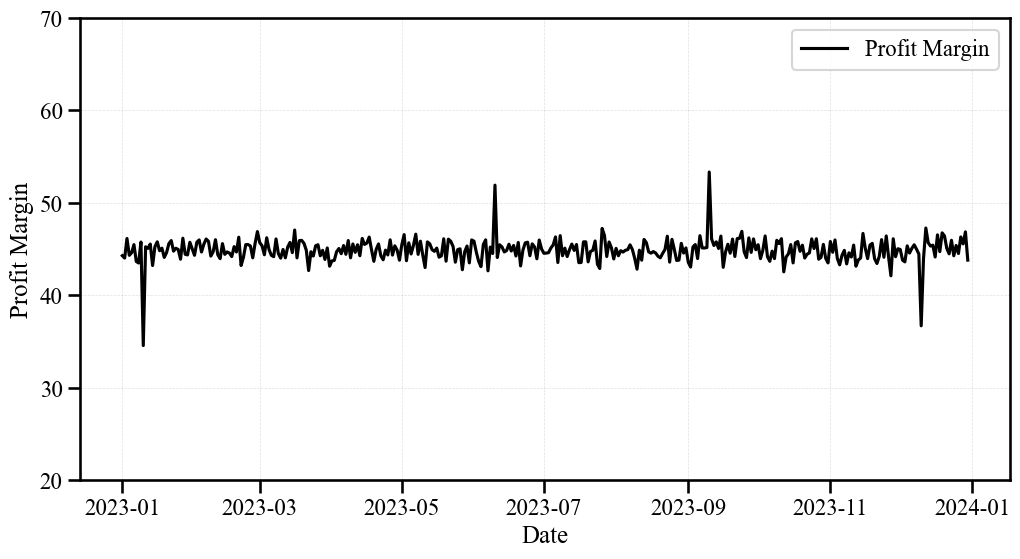

In [103]:
plt.figure(figsize=(12, 6))
# Plot the original time series.
df_anomaly_1 = df_agg.groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10 
plt.plot(df_anomaly_1["ORDERDATE"], df_anomaly_1['PROFIT_MARGIN'], 
         label='Profit Margin', color='black')

# Set plot labels and grid.
plt.xlabel("Date")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.ylim(20, 70)
plt.legend()
plt.show()


In [104]:
# Assume df_agg is your DataFrame
detector = AnomalyDetector(df_anomaly_1, date_col="ORDERDATE", value_col="PROFIT_MARGIN")
anomalies = detector.detect()
anomaly_dates = detector.get_anomaly_dates()
anomaly_dates

0   2023-01-10
1   2023-06-10
2   2023-09-10
3   2023-12-10
Name: ORDERDATE, dtype: datetime64[ns]

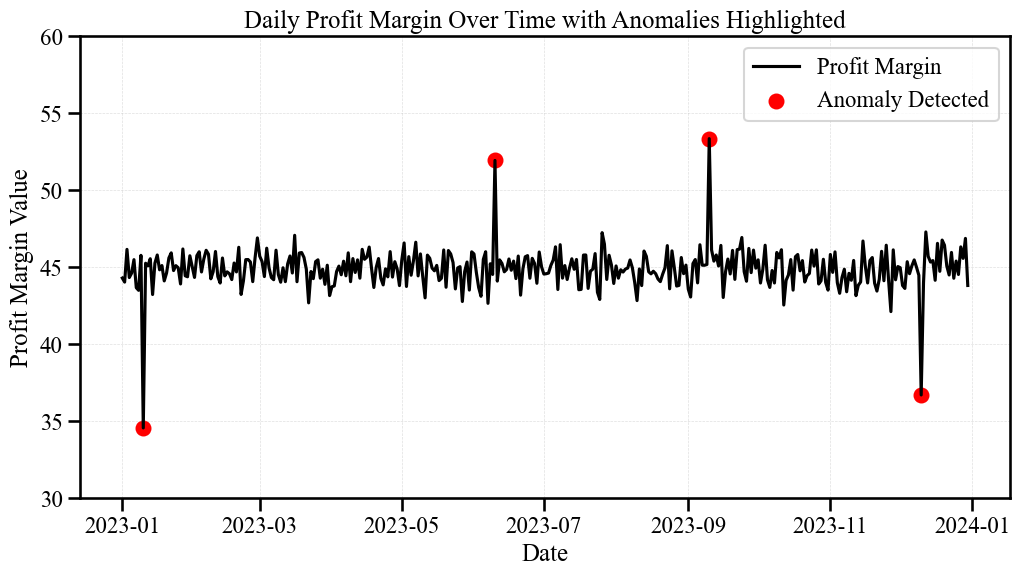

In [105]:
from graphviz import Digraph
detector.visualize(figsize=(12,6), ylim=(30,60))

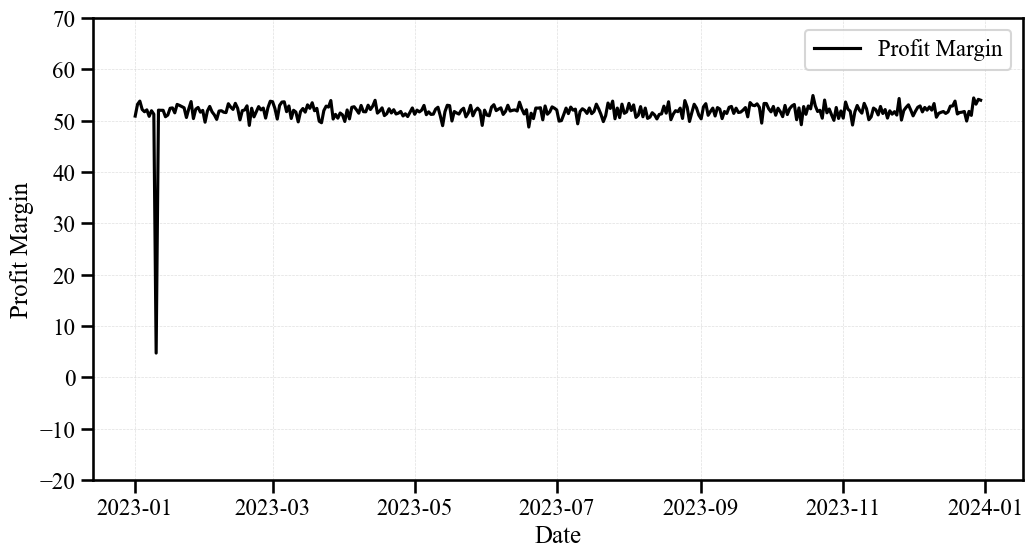

In [60]:
anomaly_schedule = {
    '2023-01-10': ('ExcessiveDiscount', 0.6, 'PricingError', 'Apparel'),
    '2023-06-10': ('COGSOverstatement', 0.8, 'SupplierIssue', 'Footwear'),
    '2023-09-10': ('FulfillmentSpike', -2, 'LogisticsIssue', 'Beauty'),
    '2023-12-10': ('ReturnSurge', -6, 'QualityIssue', 'Accessories')
}

plt.figure(figsize=(12, 6))
# Plot the original time series.
df_anomaly_disc = df_agg[df_agg['Category'] == 'Apparel'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10 
plt.plot(df_anomaly_disc["ORDERDATE"], df_anomaly_disc['PROFIT_MARGIN'], 
         label='Profit Margin', color='black')

# Set plot labels and grid.
plt.xlabel("Date")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.ylim(-20, 70)
plt.legend()
plt.show()


In [61]:
df_anomaly_disc.head()

,ORDERDATE,PRICEEACH,UNIT_COST,QUANTITYORDERED,SALES,DISCOUNT,NET_SALES,FULFILLMENT_COST,MARKETING_COST,RETURN_COST,COST_OF_GOODS_SOLD,SHIPPING_REVENUE,PROFIT,PROFIT_MARGIN,IS_MARGIN_NEGATIVE
0,2023-01-01,78.541667,19.687778,75,5773.09,605.27,5167.82,417.34,143.39,413.46,1458.66,84.0,2818.97,50.907000,0.0
1,2023-01-02,85.655349,21.393372,87,7099.82,865.50,6234.32,436.74,147.39,498.77,1750.16,69.0,3470.26,53.198372,0.0
2,2023-01-03,90.512817,22.288056,96,9101.19,1347.98,7753.21,448.16,141.67,620.25,2250.66,48.0,4340.47,53.829563,0.0
3,2023-01-04,88.111098,21.186016,90,8309.48,1279.46,7030.02,465.16,159.58,562.41,1984.90,54.0,3911.97,52.200569,0.0
4,2023-01-05,93.651477,23.115682,66,6027.55,651.99,5375.56,406.22,144.57,430.03,1471.95,63.0,2985.79,51.752614,0.0


In [107]:
from graphviz import Digraph

edges = [
    # PRICEEACH influences UNIT_COST and SALES
    ("PRICEEACH", "UNIT_COST"),
    ("PRICEEACH", "SALES"),
    
    # QUANTITYORDERED influences SALES, FULFILLMENT_COST, COST_OF_GOODS_SOLD, and SHIPPING_REVENUE
    ("QUANTITYORDERED", "SALES"),
    ("QUANTITYORDERED", "FULFILLMENT_COST"),
    ("QUANTITYORDERED", "COST_OF_GOODS_SOLD"),
    ("QUANTITYORDERED", "SHIPPING_REVENUE"),
    
    # SALES influences DISCOUNT, NET_SALES, and SHIPPING_REVENUE
    ("SALES", "DISCOUNT"),
    ("SALES", "NET_SALES"),
    ("SALES", "SHIPPING_REVENUE"),
    
    # PROMO_CODE is used in the discount calculation
    ("PROMO_CODE", "DISCOUNT"),
    
    # SALES_CHANNEL factors into DISCOUNT and FULFILLMENT_COST calculations
    ("SALES_CHANNEL", "DISCOUNT"),
    ("SALES_CHANNEL", "FULFILLMENT_COST"),
    
    # CUSTOMER_LOYALTY factors into the discount
    ("CUSTOMER_LOYALTY", "DISCOUNT"),
    
    # MERCHANDISE_HIERARCHY (which defines the product category) influences DISCOUNT, MARKETING_COST, RETURN_COST, FULFILLMENT_COST, and PRODUCTCODE
    ("Category", "DISCOUNT"),
    ("Category", "MARKETING_COST"),
    ("Category", "RETURN_COST"),
    ("Category", "FULFILLMENT_COST"),


    ("SubCategory", "DISCOUNT"),
    ("SubCategory", "MARKETING_COST"),
    ("SubCategory", "RETURN_COST"),
    ("SubCategory", "FULFILLMENT_COST"),
    
    # UNIT_COST and QUANTITYORDERED combine to form COST_OF_GOODS_SOLD
    ("UNIT_COST", "COST_OF_GOODS_SOLD"),
    
    # DISCOUNT influences NET_SALES (net sales = sales - discount)
    ("DISCOUNT", "NET_SALES"),
    
    # NET_SALES is used to compute RETURN_COST, PROFIT, and later PROFIT_MARGIN
    ("NET_SALES", "RETURN_COST"),
    ("NET_SALES", "PROFIT"),
    ("NET_SALES", "PROFIT_MARGIN"),
    
    # The cost components feed into PROFIT
    ("FULFILLMENT_COST", "PROFIT"),
    ("MARKETING_COST", "PROFIT"),
    ("RETURN_COST", "PROFIT"),
    ("COST_OF_GOODS_SOLD", "PROFIT"),
    ("SHIPPING_REVENUE", "PROFIT"),
    
    # PROFIT drives PROFIT_MARGIN and IS_MARGIN_NEGATIVE
    ("PROFIT", "PROFIT_MARGIN"),
]

dot = Digraph(comment='Variable Dependency Graph', format='png')
dot.attr(rankdir='TB')

for src, dst in edges:
    dot.edge(src, dst)

dot.render('variable_dependency_graph.gv', view=True)

'variable_dependency_graph.gv.png'

In [62]:
from graphviz import Digraph

edges = [
    # PRICEEACH influences UNIT_COST and SALES
    ("PRICEEACH", "UNIT_COST"),
    ("PRICEEACH", "SALES"),
    
    # QUANTITYORDERED influences SALES, FULFILLMENT_COST, COST_OF_GOODS_SOLD, and SHIPPING_REVENUE
    ("QUANTITYORDERED", "SALES"),
    ("QUANTITYORDERED", "FULFILLMENT_COST"),
    ("QUANTITYORDERED", "COST_OF_GOODS_SOLD"),
    ("QUANTITYORDERED", "SHIPPING_REVENUE"),
    
    # SALES influences DISCOUNT, NET_SALES, and SHIPPING_REVENUE
    ("SALES", "DISCOUNT"),
    ("SALES", "NET_SALES"),
    ("SALES", "SHIPPING_REVENUE"),
    
    
    # UNIT_COST and QUANTITYORDERED combine to form COST_OF_GOODS_SOLD
    ("UNIT_COST", "COST_OF_GOODS_SOLD"),
    
    # DISCOUNT influences NET_SALES (net sales = sales - discount)
    ("DISCOUNT", "NET_SALES"),
    
    # NET_SALES is used to compute RETURN_COST, PROFIT, and later PROFIT_MARGIN
    ("NET_SALES", "RETURN_COST"),
    ("NET_SALES", "PROFIT"),
    ("NET_SALES", "PROFIT_MARGIN"),
    
    # The cost components feed into PROFIT
    ("FULFILLMENT_COST", "PROFIT"),
    ("MARKETING_COST", "PROFIT"),
    ("RETURN_COST", "PROFIT"),
    ("COST_OF_GOODS_SOLD", "PROFIT"),
    ("SHIPPING_REVENUE", "PROFIT"),
    
    # PROFIT drives PROFIT_MARGIN and IS_MARGIN_NEGATIVE
    ("PROFIT", "PROFIT_MARGIN"),
]

dot = Digraph(comment='Variable Dependency Graph', format='png')
dot.attr(rankdir='TB')

for src, dst in edges:
    dot.edge(src, dst)

dot.render('variable_dependency_graph.gv', view=True)

'variable_dependency_graph.gv.png'

In [39]:
"""df_agg_enc = df_agg.copy()
from sklearn.preprocessing import LabelEncoder

# Assume df is your DataFrame loaded with the data

le_category = LabelEncoder()
df_agg_enc['Category'] = le_category.fit_transform(df_agg_enc['Category'])

le_subcategory = LabelEncoder()
df_agg_enc['SubCategory'] = le_subcategory.fit_transform(df_agg_enc['SubCategory'])

le_promo = LabelEncoder()
df_agg_enc['PROMO_CODE'] = le_promo.fit_transform(df_agg_enc['PROMO_CODE'])

le_sales_channel = LabelEncoder()
df_agg_enc['SALES_CHANNEL'] = le_sales_channel.fit_transform(df_agg_enc['SALES_CHANNEL'])

# Ordinal Encoding for CUSTOMER_LOYALTY:
# Define the order explicitly (e.g., "New" comes before "Loyal")
ordinal_mapping = {"New": 0, "Loyal": 1}
df_agg_enc['CUSTOMER_LOYALTY'] = df_agg_enc['CUSTOMER_LOYALTY'].map(ordinal_mapping)""";



In [35]:
"""df_agg_sample = df_agg_enc.sample(frac=0.01, random_state=42)
df_agg_sample.shape""";

In [ ]:
anomaly_schedule = {
    '2023-01-10': ('ExcessiveDiscount', 0.6, 'PricingError', 'Apparel'),
    '2023-06-10': ('COGSOverstatement', 0.8, 'SupplierIssue', 'Footwear'),
    '2023-09-10': ('FulfillmentSpike', -2, 'LogisticsIssue', 'Beauty'),
    '2023-12-10': ('ReturnSurge', -6, 'QualityIssue', 'Accessories')
}

In [85]:
# Initialize the SCM builder with visualization enabled
df_anomaly_disc = df_agg[df_agg['Category'] == 'Apparel'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
df_anomaly_foot = df_agg[df_agg['Category'] == 'Footwear'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
df_anomaly_beau = df_agg[df_agg['Category'] == 'Beauty'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()
df_anomaly_acce = df_agg[df_agg['Category'] == 'Accessories'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()

builder = ScmBuilder(edges=edges, nodes=None, visualize=False)
scm = builder.build(df=df_anomaly_disc)
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.7)
results_by_date = analyzer.analyze_by_date(df_anomaly_disc, anomaly_dates[[0]], start_node='PROFIT_MARGIN')

# You can then inspect the results for each anomaly date:
for ad, result in results_by_date.items():
    print(f"\nResults for anomaly date {ad}:")
    for path, score in result['paths']:
        print(f"Path with significance {score:.4f}: {path}")

Automatically assigning causal mechanisms...
Fitting the Structural Causal Model...


Fitting causal mechanism of node MARKETING_COST: 100%|██████████| 13/13 [00:00<00:00, 39.29it/s]   



--- Analyzing anomaly date: 2023-01-10 00:00:00 ---


Evaluating set functions...: 100%|██████████| 2/2 [00:00<00:00, 1016.43it/s]



Found 2 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.0865):
├─ PROFIT_MARGIN        (Combined Score: 0.4170, Noise Contribution: 0.0383)
  ├─ NET_SALES            (Combined Score: 0.7844, Noise Contribution: 0.0999)
    └─ DISCOUNT             (Combined Score: 0.8186, Noise Contribution: 0.1236)

Path 2 (Causal Significance: 0.0292):
├─ PROFIT_MARGIN        (Combined Score: 0.4170, Noise Contribution: 0.0383)
  └─ PROFIT               (Combined Score: 0.8067, Noise Contribution: 0.0417)

Results for anomaly date 2023-01-10 00:00:00:
Path with significance 0.0865: [('PROFIT_MARGIN', 0.4169692202032106), ('NET_SALES', 0.784368583284043), ('DISCOUNT', 0.8186355389153146)]
Path with significance 0.0292: [('PROFIT_MARGIN', 0.4169692202032106), ('PROFIT', 0.8066810366333731)]


c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [96]:
df_anomaly_foot = df_agg[df_agg['Category'] == 'Footwear'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()

builder = ScmBuilder(edges=edges, nodes=None, visualize=False)
scm = builder.build(df=df_anomaly_foot)
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.7)
results_by_date = analyzer.analyze_by_date(df_anomaly_foot, anomaly_dates[[1]], start_node='PROFIT_MARGIN')

# You can then inspect the results for each anomaly date:
for ad, result in results_by_date.items():
    print(f"\nResults for anomaly date {ad}:")
    for path, score in result['paths']:
        print(f"Path with significance {score:.4f}: {path}")

Automatically assigning causal mechanisms...
Fitting the Structural Causal Model...


Fitting causal mechanism of node MARKETING_COST: 100%|██████████| 13/13 [00:00<00:00, 13.67it/s]   



--- Analyzing anomaly date: 2023-06-10 00:00:00 ---


Evaluating set functions...: 100%|██████████| 2/2 [00:00<00:00, 1996.34it/s]



Found 2 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.1743):
├─ PROFIT_MARGIN        (Combined Score: 0.7939, Noise Contribution: 0.0384)
  ├─ PROFIT               (Combined Score: 0.8834, Noise Contribution: 0.0412)
    ├─ COST_OF_GOODS_SOLD   (Combined Score: 0.7295, Noise Contribution: 0.1242)
      └─ UNIT_COST            (Combined Score: 0.9007, Noise Contribution: 0.2490)

Path 2 (Causal Significance: -0.0076):
├─ PROFIT_MARGIN        (Combined Score: 0.7939, Noise Contribution: 0.0384)
  ├─ PROFIT               (Combined Score: 0.8834, Noise Contribution: 0.0412)
    └─ FULFILLMENT_COST     (Combined Score: 0.7332, Noise Contribution: -0.0108)

Results for anomaly date 2023-06-10 00:00:00:
Path with significance 0.1743: [('PROFIT_MARGIN', 0.7938614905986785), ('PROFIT', 0.8834065041798638), ('COST_OF_GOODS_SOLD', 0.7294886189266496), ('UNIT_COST',

c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [87]:
builder = ScmBuilder(edges=edges, nodes=None, visualize=False)
scm = builder.build(df=df_anomaly_beau)
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.7)
results_by_date = analyzer.analyze_by_date(df_anomaly_beau, anomaly_dates[[2]], start_node='PROFIT_MARGIN')

# You can then inspect the results for each anomaly date:
for ad, result in results_by_date.items():
    print(f"\nResults for anomaly date {ad}:")
    for path, score in result['paths']:
        print(f"Path with significance {score:.4f}: {path}")

Automatically assigning causal mechanisms...
Fitting the Structural Causal Model...


Fitting causal mechanism of node MARKETING_COST: 100%|██████████| 13/13 [00:00<00:00, 88.62it/s]


--- Analyzing anomaly date: 2023-09-10 00:00:00 ---



Evaluating set functions...: 100%|██████████| 2/2 [00:00<00:00, 2033.11it/s]



Found 2 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.1747):
├─ PROFIT_MARGIN        (Combined Score: 0.8166, Noise Contribution: 0.0384)
  ├─ PROFIT               (Combined Score: 0.8001, Noise Contribution: 0.0326)
    └─ FULFILLMENT_COST     (Combined Score: 0.8306, Noise Contribution: 0.2496)

Path 2 (Causal Significance: 0.0420):
├─ PROFIT_MARGIN        (Combined Score: 0.8166, Noise Contribution: 0.0384)
  └─ NET_SALES            (Combined Score: 0.7512, Noise Contribution: 0.0600)

Results for anomaly date 2023-09-10 00:00:00:
Path with significance 0.1747: [('PROFIT_MARGIN', 0.8166339205855779), ('PROFIT', 0.8001071750856827), ('FULFILLMENT_COST', 0.8305942421522694)]
Path with significance 0.0420: [('PROFIT_MARGIN', 0.8166339205855779), ('NET_SALES', 0.7511586298747248)]


c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [106]:
df_anomaly_acce = df_agg[df_agg['Category'] == 'Accessories'].groupby([pd.Grouper(key='ORDERDATE', freq='D')]).agg(aggregation_dict).reset_index()

builder = ScmBuilder(edges=edges, nodes=None, visualize=False)
scm = builder.build(df=df_anomaly_acce)
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.7)
results_by_date = analyzer.analyze_by_date(df_anomaly_acce, anomaly_dates[[3]], start_node='PROFIT_MARGIN')

# You can then inspect the results for each anomaly date:
for ad, result in results_by_date.items():
    print(f"\nResults for anomaly date {ad}:")
    for path, score in result['paths']:
        print(f"Path with significance {score:.4f}: {path}")

Automatically assigning causal mechanisms...
Fitting the Structural Causal Model...


Fitting causal mechanism of node MARKETING_COST: 100%|██████████| 13/13 [00:00<00:00, 18.43it/s]   



--- Analyzing anomaly date: 2023-12-10 00:00:00 ---


Evaluating set functions...: 100%|██████████| 2/2 [00:00<?, ?it/s]



Found 3 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.0658):
├─ PROFIT_MARGIN        (Combined Score: 0.1854, Noise Contribution: 0.0384)
  └─ NET_SALES            (Combined Score: 0.7715, Noise Contribution: 0.0941)

Path 2 (Causal Significance: 0.0576):
├─ PROFIT_MARGIN        (Combined Score: 0.1854, Noise Contribution: 0.0384)
  ├─ PROFIT               (Combined Score: 0.8026, Noise Contribution: 0.0416)
    └─ RETURN_COST          (Combined Score: 0.8336, Noise Contribution: 0.0823)

Path 3 (Causal Significance: 0.0031):
├─ PROFIT_MARGIN        (Combined Score: 0.1854, Noise Contribution: 0.0384)
  ├─ PROFIT               (Combined Score: 0.8026, Noise Contribution: 0.0416)
    └─ SHIPPING_REVENUE     (Combined Score: 0.7117, Noise Contribution: 0.0044)

Results for anomaly date 2023-12-10 00:00:00:
Path with significance 0.0658: [('PROFIT_MARGIN', 

c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
